<a href="https://colab.research.google.com/github/yfb2022/STAT_DL_INTRO/blob/main/5_3_using_a_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Using a pre-trained convnet

소규모 이미지 데이터 세트에 대한 딥 러닝에 대한 일반적이고 매우 효과적인 접근 방식은 사전 훈련된 네트워크를 활용하는 것입니다.

사전 훈련된 네트워크: 대규모 이미지 분류 작업에 대해 대규모 데이터 세트에 대해 이전에 훈련된 저장된 네트워크입니다.

_사전 훈련된 네트워크를 활용하는 방법 : 특징 추출_ 과 _미세 조정이라는_ 두 가지 방법이 있습니다

## Feature extraction

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

특징 추출: 이전 네트워크에서 학습한 컨볼루션 표현을 사용하여 새 샘플에서 흥미로운 피처를 추출
그 후 훈련된 새로운 분류기를 통해 실행됩니다.

CONVNET:

1) 일련의 풀링 및 컨볼루션 레이어

2) FC Classifier.



사전훈련 모델:
* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet



In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, 모델을 초기화할 가중치 체크포인트 지정
* `include_top`, FC Classifier를 네트워크 위에 포함할지의 여부. 기본적으로 FC-Classifier는 ImageNet의 1000개 클래스에 해당.

* `input_shape`,네트워크에 공급할 이미지 텐서의 모양 이 인수를 전달하지 않으면 네트워크는 모든 크기의 입력을 처리.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

최종 피처맵의 모양은 (4, 4, 512).

1) 데이터 세트에 대해 컨볼루셔널 기반을 실행하고 그 출력을 디스크의 배열에 기록한 다음 이 데이터를 FC-Classifier에 대한 입력으로 사용.

이 솔루션은 모든 입력 이미지에 대해 컨벌루션 기반을 한 번만 실행하면 되고 컨벌루션 기반은 파이프라인에서 단연 가장 비용이 많이 드는 부분이기 때문에 실행이 빠르고 저렴. 그러나 같은 이유로 이 기술에서는 데이터 증대를 사용 불가.

2) conv_base 상단에 Dense 레이어를 추가

이렇게 하면 모든 입력 이미지가 컨볼루션 기반을 통과하므로 데이터 증대를 사용할 수 있으나 소요 시간이 많음.

In [ ]:
%cd /content/drive/My Drive/DeepLearning/Programs/deep-learning-with-r-notebooks-master/notebooks

[Errno 2] No such file or directory: '/content/drive/My Drive/DeepLearning/Programs/deep-learning-with-r-notebooks-master/notebooks'
/content


In [ ]:
!ls

sample_data


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'cats_and_dogs_small'
# 경로 설정
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
# 스케일링
datagen = ImageDataGenerator(rescale=1./255) #
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

FileNotFoundError: [Errno 2] No such file or directory: 'cats_and_dogs_small/train'

추출피처 모양: (samples, 4, 4, 512).

이를 Densely-Connected Layer에 입력하기위해 Flatten.`(samples, 8192)`:

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 570us/step - loss: 0.6370 - acc: 0.6225 - val_loss: 0.4622 - val_acc: 0.8210
Epoch 2/30
2000/2000 [==============================] - 1s 385us/step - loss: 0.4380 - acc: 0.8065 - val_loss: 0.3772 - val_acc: 0.8510
Epoch 3/30
2000/2000 [==============================] - 1s 403us/step - loss: 0.3626 - acc: 0.8465 - val_loss: 0.3333 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 1s 396us/step - loss: 0.3191 - acc: 0.8705 - val_loss: 0.3121 - val_acc: 0.8730
Epoch 5/30
2000/2000 [==============================] - 1s 406us/step - loss: 0.2935 - acc: 0.8855 - val_loss: 0.2902 - val_acc: 0.8920
Epoch 6/30
2000/2000 [==============================] - 1s

두 Dense Layer만 처리하면 되기에 훈련이 빠름

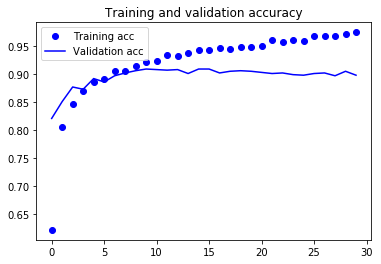

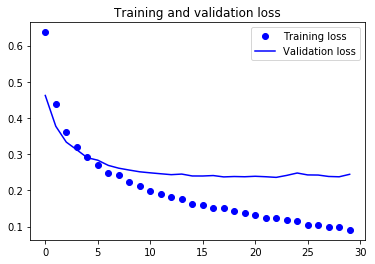

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

정확도는 90%, 그러나 드롭아웃을 사용했음에도 불구하고 거의 처음부터 과적합. 이는 필수적인 데이터 증대를 활용하지 않기 때문임.

데이터 증대는 conv_base 모델을 확장하고 입력에 대해 엔드투엔드를 실행하는 것.

conv_base모델은 레이어처럼 동작하므로 레이어를 추가하는 것처럼 Sequential 모델에 모델을 추가할 수 있음.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


모델을 컴파일하고 훈련하기 전에 컨볼루셔널 기반을 얼리는 것이 매우 중요함. 레이어 또는 레이어 세트를 고정한다는 것은 훈련 중에 해당 가중치가 업데이트되지 않는다는 것을 의미. 이렇게 하지 않으면 이전에 컨볼루셔널 기반에서 학습한 표현이 훈련 중에 수정됨. 상단의 Dense 레이어는 무작위로 초기화되기 때문에 매우 큰 가중치 업데이트가 네트워크를 통해 전파되어 이전에 학습된 표현을 파괴함.



In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


이 설정을 사용하면 추가한 두 Dense 레이어의 가중치만 훈련됨. 이는 총 4개의 가중치 텐서. 레이어당 2개(주 가중치 행렬과 bias 벡터)입니다. 이러한 변경 사항을 적용하려면 먼저 모델을 컴파일해야 합니다. 컴파일 후 weight 훈련 가능성을 수정하는 경우 모델을 다시 컴파일. 그렇지 않으면 이러한 변경 사항이 무시됨.



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 29s - loss: 0.5888 - acc: 0.6895 - val_loss: 0.4439 - val_acc: 0.8260
Epoch 2/30
 - 27s - loss: 0.4853 - acc: 0.7880 - val_loss: 0.3635 - val_acc: 0.8690
Epoch 3/30
 - 27s - loss: 0.4307 - acc: 0.8160 - val_loss: 0.3252 - val_acc: 0.8720
Epoch 4/30
 - 26s - loss: 0.4080 - acc: 0.8180 - val_loss: 0.3050 - val_acc: 0.8770
Epoch 5/30
 - 27s - loss: 0.3821 - acc: 0.8320 - val_loss: 0.2887 - val_acc: 0.8840
Epoch 6/30
 - 27s - loss: 0.3623 - acc: 0.8390 - val_loss: 0.2803 - val_acc: 0.8890
Epoch 7/30
 - 26s - loss: 0.3604 - acc: 0.8355 - val_loss: 0.2677 - val_acc: 0.8890
Epoch 8/30
 - 27s - loss: 0.3514 - acc: 0.8490 - val_loss: 0.2675 - val_acc: 0.8920
Epoch 9/30
 - 27s - loss: 0.3528 - acc: 0.8455 - val_loss: 0.2558 - val_acc: 0.8940
Epoch 10/30
 - 27s - loss: 0.3301 - acc: 0.8590 - val_loss: 0.2583 - val_acc: 0.8930
Epoch 11/30
 - 26s - loss: 0.3366 - acc: 0.8555 - val_loss: 0.2487 - val_ac

In [ ]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

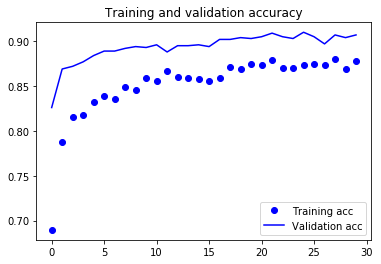

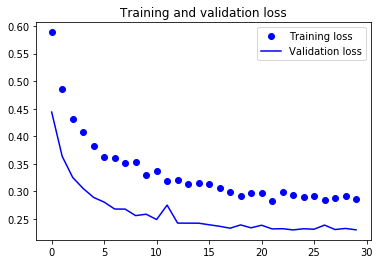

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

보시다시피 우리는 약 96%의 검증 정확도에 도달함. 이것은 처음부터 훈련된 작은 컨브넷보다 훨씬 좋음.

## Fine-tuning

특징 추출을 보완하는 모델 재사용을 위해 널리 사용되는 기술은 미세 조정. 미세 조정은 특징 추출에 사용되는 고정된 모델 기반의 상위 레이어 몇 개를 고정 해제하고 모델의 새로 추가된 부분(이 경우 완전 연결 분류기)과 이러한 상위 레이어를 공동으로 훈련.

상단에 있는 분류기가 이미 훈련된 후에만 컨볼루션 기반의 상단 레이어를 미세 조정하는 것이 가능. 분류된 항목이 아직 훈련되지 않은 경우 훈련 중에 네트워크를 통해 전파되는 오류 신호가 너무 커지고 미세 조정 중인 레이어에서 이전에 학습한 표현이 파괴.

Stage

1) 이미 학습된 기본 네트워크 위에 사용자 지정 네트워크를 추가합니다.

2) 기본 네트워크를 동결합니다.

3) 추가한 부분을 훈련시킵니다.

4) 기본 네트워크의 일부 레이어를 동결 해제합니다.

5) 이 레이어와 추가한 부분을 공동으로 훈련합니다.

특징추출 : ~3단계

4단계 부터 시작

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

마지막 3개의 컨볼루셔널 레이어를 미세 조정.

즉, block4_pool까지의 모든 레이어는 동결되어야 하고 레이어 block5_conv1, block5_conv2및 block5_conv3는 훈련 가능해야 함.

더 많은 레이어 또는 전체 컨볼루션 기반을 파인튜닝?

컨벌루션 기반의 이전 레이어는 보다 일반적이고 재사용 가능한 기능을 인코딩하고, 상위 레이어는 보다 전문적인 기능을 인코딩함. 보다 전문화된 기능을 미세 조정하는 것이 더 유용. 이러한 기능은 새로운 문제에 대해 용도를 변경해야하기 때문임.

더 많은 매개변수를 훈련할수록 과적합 위험이 커짐.
따라서 convolutional base의 상위 2~3개 레이어만 미세 조정하는 것이 좋은 전략입니다.

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

이제 네트워크 미세 조정을 시작할 수 있음. 우리는 매우 낮은 학습률을 사용하는 RMSprop 최적화 프로그램을 사용하여 이를 수행. 낮은 학습률을 사용하는 이유는 미세 조정 중인 3개 레이어의 표현에 대한 수정 크기를 제한하고 싶기 때문. 업데이트가 너무 크면 이러한 표현이 손상될 수 있음.


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 31s 306ms/step - loss: 0.2747 - acc: 0.8740 - val_loss: 0.2175 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 28s 281ms/step - loss: 0.2411 - acc: 0.8985 - val_loss: 0.2107 - val_acc: 0.9210
Epoch 3/100
100/100 [==============================] - 28s 280ms/step - loss: 0.2444 - acc: 0.8880 - val_loss: 0.1980 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 28s 278ms/step - loss: 0.2146 - acc: 0.9165 - val_loss: 0.2184 - val_acc: 0.9160
Epoch 5/100
100/100 [==============================] - 28s 280ms/step - loss: 0.2080 - acc: 0.9170 - val_loss: 0.1907 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 28s 278ms/step - loss: 0.2017 - acc: 0.9170 - val_loss: 0.1933 - val_acc: 0.9250
Epoch 7/100
100/100 [==============================] - 28s 278ms/step - loss: 0.1800 - acc: 0.9190 - val_loss: 0.2094 - val_acc: 0.9240
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

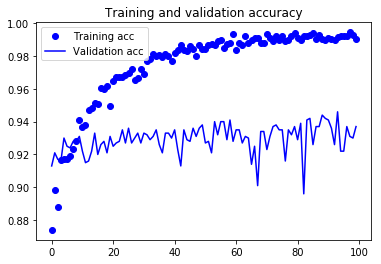

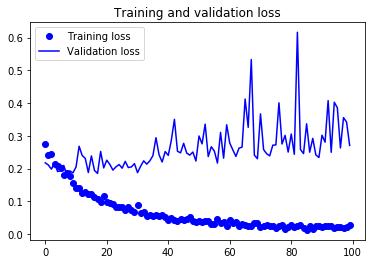

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

더 읽기 쉽게 만들기 위해 모든 손실과 정확도를 이러한 수량의 지수 이동 평균으로 대체하여 평활화

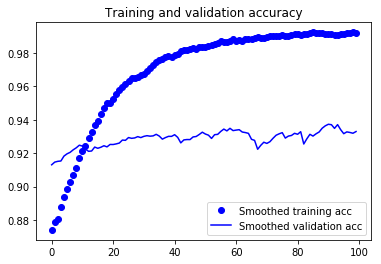

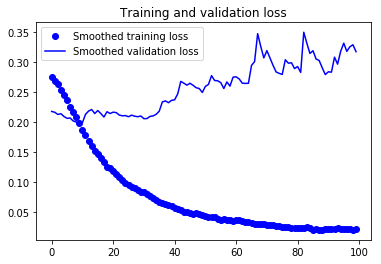

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

손실 곡선은 실질적인 개선을 나타내지 않습니다(사실 악화되고 있음). 손실이 감소하지 않으면 어떻게 정확도가 향상될 수 있는지 궁금할것입니다.  우리가 표시하는 것은 점 별 손실 값의 평균이지만 실제로 정확도에 중요한 것은 평균이 아니라 손실 값의 분포. 왜냐하면 정확도는 모델에 의해 예측된 클래스 확률의 이진 임계값 결과. 이것이 평균 손실에 반영되지 않더라도 모델은 여전히 ​​개선되고 있을 수 있음.

이제 테스트 데이터에서 이 모델을 최종적으로 평가할 수 있습니다.

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9439999914169311


97%의 테스트 정확도  2000개의 샘플 사용

## Take-aways: using convnets with small datasets

* Convnet은 컴퓨터 비전 작업을 위한 최고의 기계 학습 모델 유형. 매우 작은 데이터 세트에서도 처음부터 훈련하여 괜찮은 결과를 얻을 수 있음.

* 작은 데이터 세트에서는 과적합이 주요 문제. 데이터 증대는 이미지 데이터 작업 시 과적합을 방지하는 강력한 방법.

* 특징 추출을 통해 새 데이터세트에서 기존 ConvNet을 쉽게 재사용할 수 있음. 이는 작은 이미지 데이터 세트로 작업하는 데 매우 유용한 기술.

* 특징 추출을 보완하기 위해 기존 모델에서 이전에 학습한 일부 표현을 새로운 문제에 맞게 조정하는 파인튜닝을 사용할 수 있음. 이로 인해 성능이 조금 더 향상됨.
